#### Same as viz, but for the NLGP dataset

In [1]:
import os
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import optax
import datasets
import models
import samplers
import matplotlib.pyplot as plt
from conv_emergence import compute_entropy as entropy
from localization.experiments import make_key, simulate
from viz_box import position_mean_var, ipr, entropy_sort, mean_sort, var_sort, plot_receptive_fields

In [32]:
config = dict(
    seed=0,
    num_dimensions=40,
    num_hiddens=100,
    gain=1.1,
    init_scale=1.0,
    activation='tanh',
    model_cls=models.SimpleNet,
    optimizer_fn=optax.sgd,
    learning_rate=1.0,
    batch_size=5000,
    num_epochs=200,
    dataset_cls=datasets.NonlinearGPDataset,
    xi1=4.47,
    xi2=0.1,
    class_proportion=0.5,
    sampler_cls=samplers.EpochSampler,
    init_fn=models.torch_init,
    save_=False,
)

#### Let's see how the weights evolve over time.

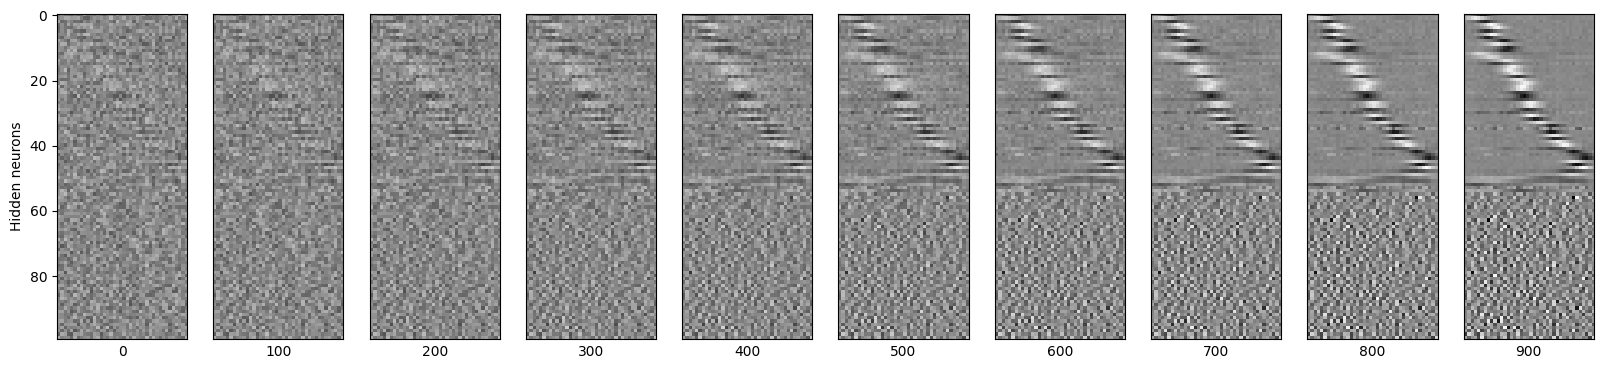

In [35]:
# path_key = make_key(**config)
# weights = np.load(f"results/weights/{path_key}/fc1.npy")
evaluation_interval = 100
path_key = "xi1=04.47_xi2=00.10_gain=100.00_L=100_K=040_dim=1_batch_size=100_num_epochs=1000_loss=mse_lr=1.000_activation=tanh_second_layer=0.0_init_scale=1.000"
weights = np.stack([ np.load(f"results/weights/{path_key}/fc1_{i}.npy") for i in range(100, 1001, 100) ])
fig, axs = plot_receptive_fields(weights, num_cols=20, figsize=(40, 20), reordering_fn=entropy_sort, ind=-1, center_sort=True, evaluation_interval=evaluation_interval)
# fig.savefig(f"results/weights/{path_key}/receptive_fields.png", dpi=300, bbox_inches='tight')

#### Now, let's see how some metrics change over time.

We'll focus on loss, accuracy, IPR, and entropy for now.

In [4]:
# metrics = pd.read_csv(f"results/weights/{path_key}/metrics.csv")
loss_ = np.zeros(10) #metrics['loss'].values
accuracy_ = np.zeros(10) #metrics['accuracy'].values
ipr_ = np.stack([ ipr(weight_) for weight_ in weights ])
entropy_ = np.stack([ entropy(weight_) for weight_ in weights ])

It seems like IPR for discriminating between localized and "oscillatory" receptive fields for the NLGP dataset, unlike entropy.

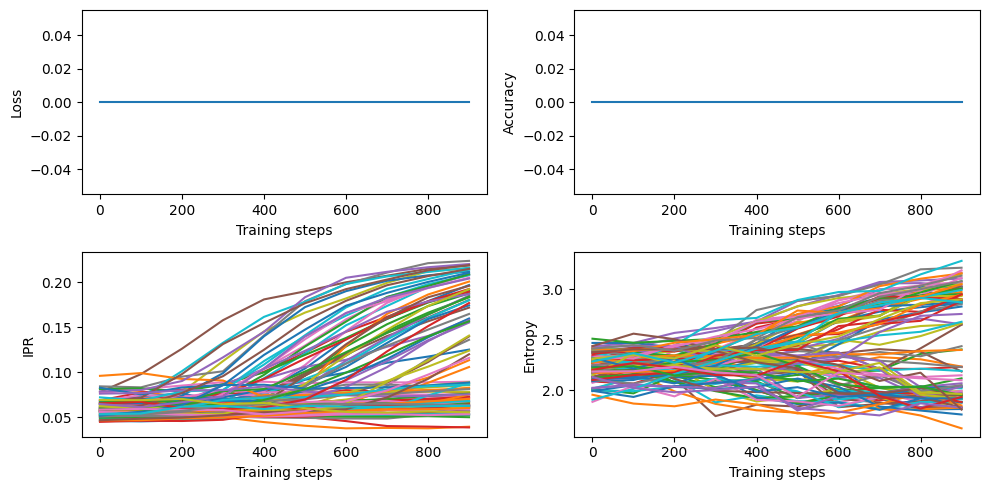

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
for ax, metric, label in zip(axs.flatten(), [loss_, accuracy_, ipr_, entropy_], ['Loss', 'Accuracy', 'IPR', 'Entropy']):
    ax.plot(evaluation_interval * np.arange(len(metric)), metric)
    ax.set_xlabel('Training steps')
    ax.set_ylabel(label)
fig.tight_layout()

#### Now, let's see what the weights actually look like.

That is, which kernel are the localized receptive field learning?

Looks like localized receptive fields have a baseline at 0 and go up to plus or minus 0.5.
The oscillatory receptive fields hover around 0.

This plot (as well the full set of receptive fields above) shows us that all the localized receptive fields have roughly the same bandwidth of about five units.

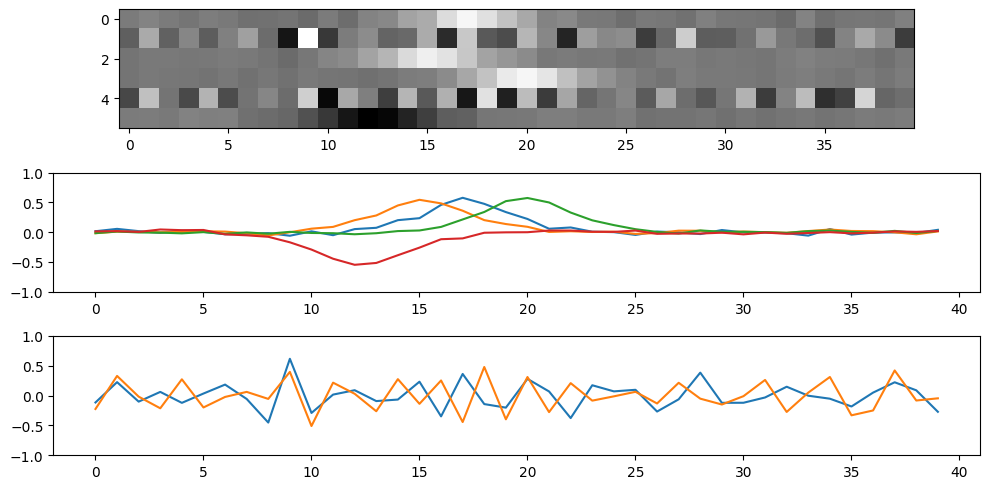

In [6]:
# Let's pick out a few weights to visualize
localized_inds = np.array([0, 2, 3, 5])
oscillatory_inds = np.array([1, 4])
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5))
ax1.imshow(weights[-1][:6], cmap='gray')
ax2.plot(weights[-1][localized_inds].T)
ax2.set_ylim(-1, 1)
ax3.plot(weights[-1][oscillatory_inds].T)
ax3.set_ylim(-1, 1)
fig.tight_layout()

#### Now, let's see how the localized and oscillatory receptive fields evolve over time.

First, we'll visualize each receptive fields at various points in time.
Then, we'll see how the group evolves over time.

We'll see that the localized receptive fields' kernels begin to emerge immediately and grow in magnitude continuously and uniformly throughout training.
Unlike in the single-pulse case, the oscillatory receptive fields **do change**.
They grow in magnitude, but just with much smaller bandwidths.
The localized receptive fields smooth out to become nice Gaussian-looking bumps.

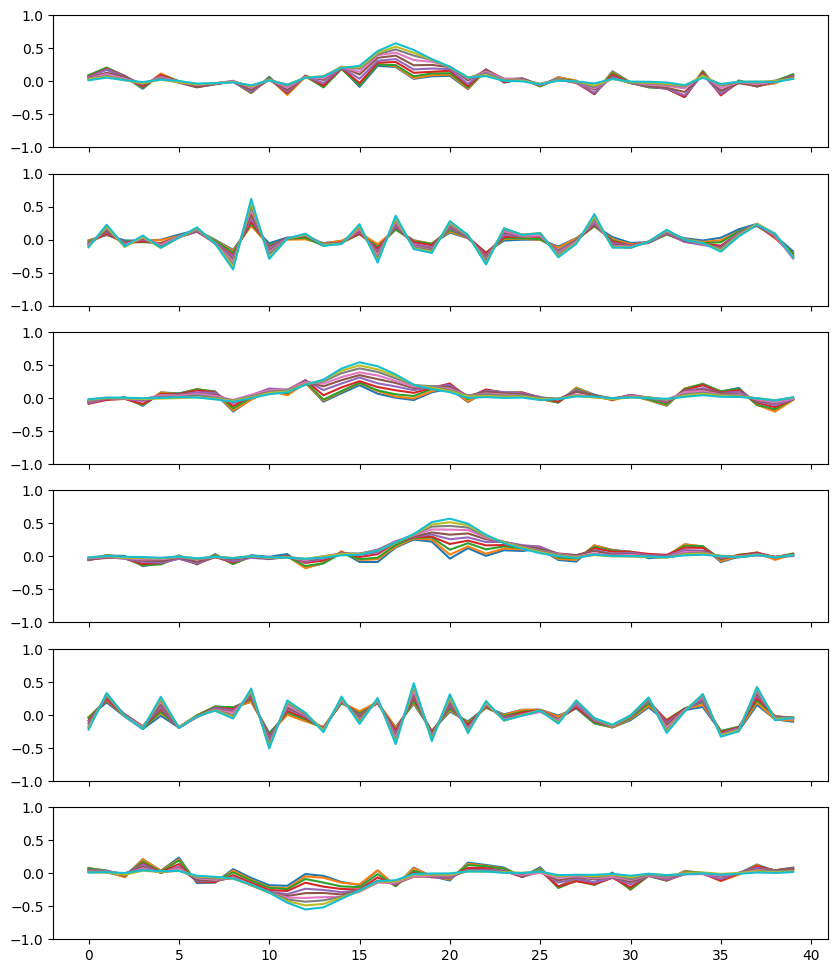

In [7]:
fig, axs = plt.subplots(6, 1, figsize=(10, 12), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(weights[:,i,:].T)
    ax.set_ylim(-1, 1)

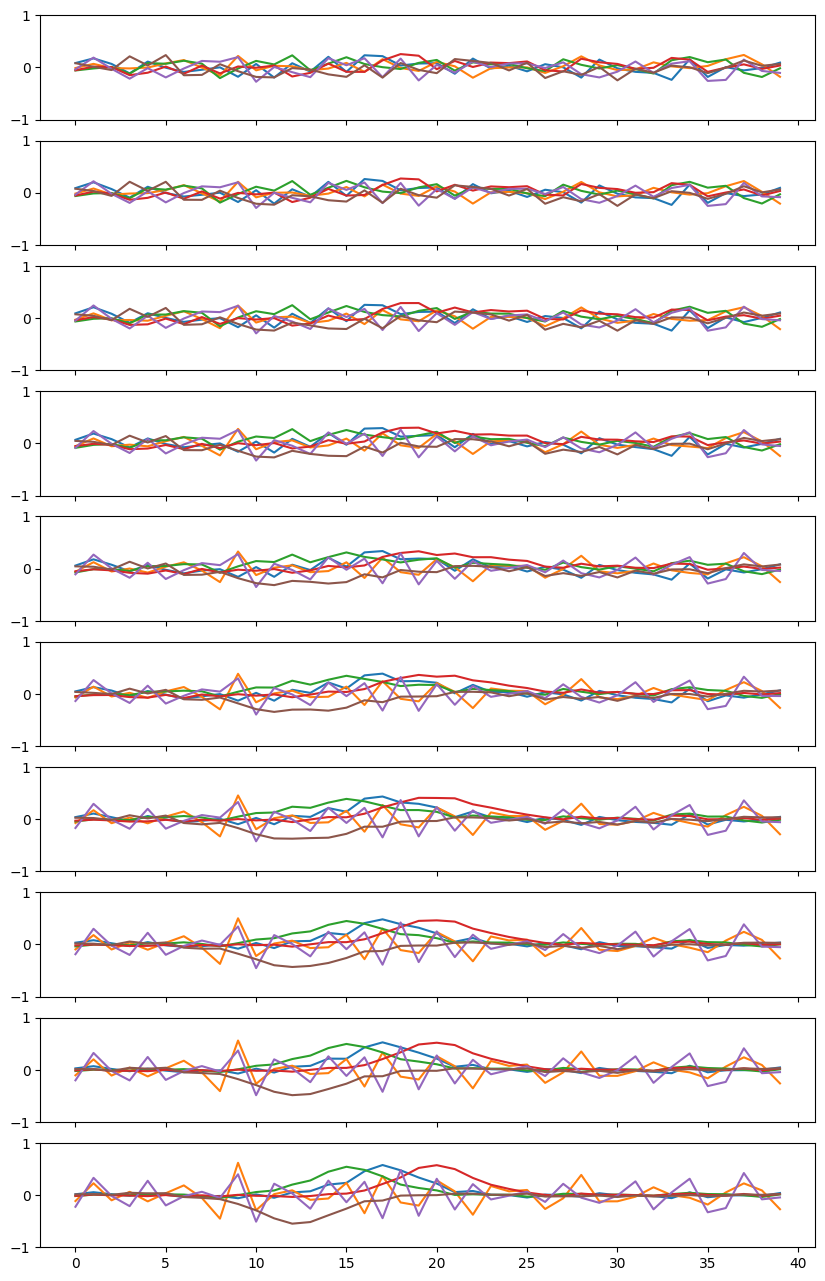

In [8]:
fig, axs = plt.subplots(10, 1, figsize=(10, 16), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(weights[i,:6,:].T)
    ax.set_ylim(-1, 1)

Text(0, 0.5, 'Mean weight magnitude')

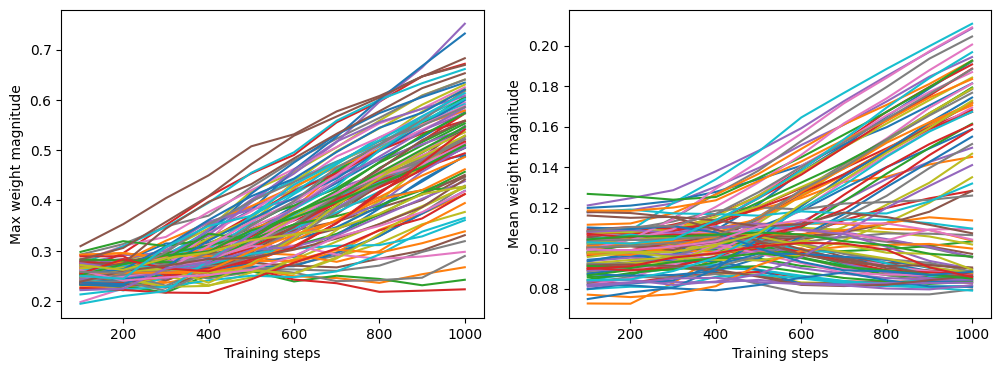

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot( np.arange(1,11) * evaluation_interval, np.max(np.abs(weights), axis=2) )
ax1.set_xlabel('Training steps')
ax1.set_ylabel('Max weight magnitude')
ax2.plot( np.arange(1,11) * evaluation_interval, np.mean(np.abs(weights), axis=2) )
ax2.set_xlabel('Training steps')
ax2.set_ylabel('Mean weight magnitude')

#### Pruning oscillatory neurons

Let's see how much behavior changes when we prune the oscillatory neurons.
We'll sort them using IPR, which seems to be the most reliable metric for the NLGP dataset.

In [17]:
localized_mask = ipr(weights[-1]) > 0.1
weights_ = weights[-1]
weights_localized = weights_[localized_mask]

def forward(weight, x, K=100):
    h = np.tanh(weight @ x)
    z = np.sum(h, axis=0) / K
    # z = np.mean(h, axis=0)
    return z

dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config)
x, y = dataset[:1000]

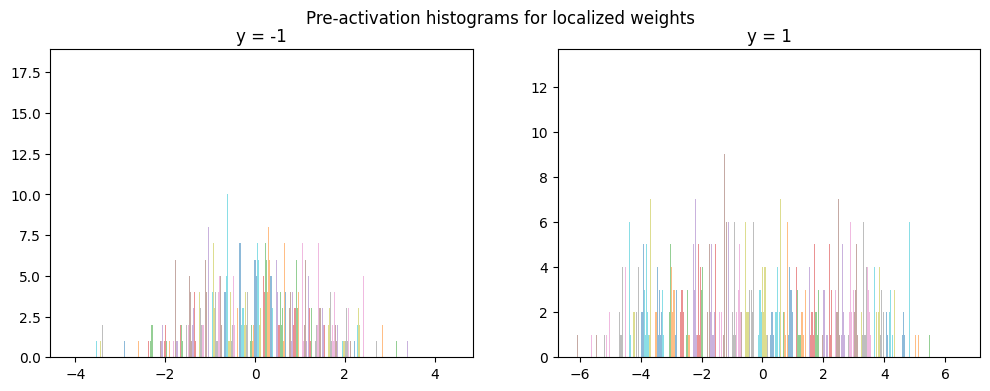

In [22]:
pre_h = weights_[localized_mask] @ x[:200].T
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(pre_h[:,y[:200] == -1].T, bins=30, alpha=0.5, label='y = -1')
ax2.hist(pre_h[:,y[:200] == 1].T, bins=30, alpha=0.5, label='y = 1')
ax1.set_title('y = -1')
ax2.set_title('y = 1')
_ = fig.suptitle('Pre-activation histograms for localized weights')

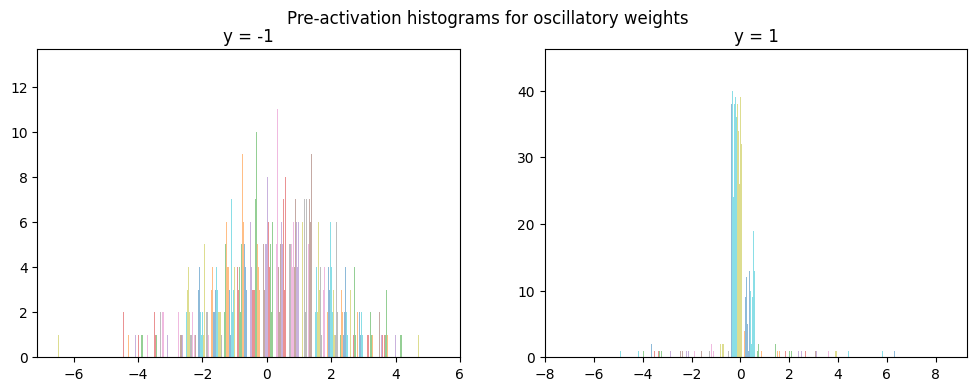

In [23]:
pre_h = weights_[~localized_mask] @ x[:200].T
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(pre_h[:,y[:200] == -1].T, bins=30, alpha=0.5, label='y = -1')
ax2.hist(pre_h[:,y[:200] == 1].T, bins=30, alpha=0.5, label='y = 1')
ax1.set_title('y = -1')
ax2.set_title('y = 1')
_ = fig.suptitle('Pre-activation histograms for oscillatory weights')

In [28]:
[ np.mean(( forward(weight_, x.T) - y ) ** 2) for weight_ in weights ]

[Array(0.9986093, dtype=float32),
 Array(1.0092167, dtype=float32),
 Array(1.0011617, dtype=float32),
 Array(1.0056225, dtype=float32),
 Array(1.002149, dtype=float32),
 Array(1.0028436, dtype=float32),
 Array(1.0021791, dtype=float32),
 Array(1.0027457, dtype=float32),
 Array(1.0002557, dtype=float32),
 Array(1.0036094, dtype=float32)]

In [29]:
[ np.mean( (forward(weight_, x.T) > 0) == (y > 0) ) for weight_ in weights ]

[Array(0.51900005, dtype=float32),
 Array(0.48000002, dtype=float32),
 Array(0.513, dtype=float32),
 Array(0.46800002, dtype=float32),
 Array(0.49600002, dtype=float32),
 Array(0.49300003, dtype=float32),
 Array(0.47900003, dtype=float32),
 Array(0.503, dtype=float32),
 Array(0.51000005, dtype=float32),
 Array(0.47800002, dtype=float32)]